In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-3e29mai9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-3e29mai9
  Resolved https://github.com/facebookresearch/fvcore.git to commit 51092b5515cbb493f73de079743dd6b11cc4bbf1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65405 sha256=d1ec0bf5f2741c0eff424077f2533abc7101108a3df3f39146cb5bdb0a3e3440
  Stored in directory: /tmp/pip-ephem-wheel-cache-9yttysb8/wheels/1a/ae/26/d93adc5470e3323d9144ccbcb7b8be77f040ec5087c3839d70
  Created wheel for iopath: filename=

In [1]:
import torch, torchvision, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline


from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 427
        record["width"] = 640
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
classes = ['keychain']

data_path = '/content/drive/MyDrive/keychain/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 300    
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 


In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/18 09:48:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 170MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/18 09:48:34 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/18 09:48:47 d2.utils.events]:  eta: 0:02:07  iter: 19  total_loss: 2.039  loss_cls: 0.8281  loss_box_reg: 0.4703  loss_mask: 0.6922  loss_rpn_cls: 0.0154  loss_rpn_loc: 0.01033    time: 0.4598  last_time: 0.4300  data_time: 0.0376  last_data_time: 0.0121   lr: 1.6068e-05  max_mem: 2456M
[04/18 09:48:59 d2.utils.events]:  eta: 0:01:58  iter: 39  total_loss: 1.889  loss_cls: 0.6151  loss_box_reg: 0.5155  loss_mask: 0.6738  loss_rpn_cls: 0.008467  loss_rpn_loc: 0.007744    time: 0.4590  last_time: 0.3964  data_time: 0.0123  last_data_time: 0.0160   lr: 3.2718e-05  max_mem: 2456M
[04/18 09:49:08 d2.utils.events]:  eta: 0:01:47  iter: 59  total_loss: 1.621  loss_cls: 0.4456  loss_box_reg: 0.5261  loss_mask: 0.6263  loss_rpn_cls: 0.01288  loss_rpn_loc: 0.009408    time: 0.4534  last_time: 0.4855  data_time: 0.0075  last_data_time: 0.0091   lr: 4.9367e-05  max_mem: 2456M
[04/18 09:49:17 d2.utils.events]:  eta: 0:01:38  iter: 79  total_loss: 1.469  loss_cls: 0.3636  loss_box_reg: 0.4977  l

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("category_test", )
predictor = DefaultPredictor(cfg)

test_dataset_dicts = get_data_dicts(data_path+'test', classes)

[04/18 09:51:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


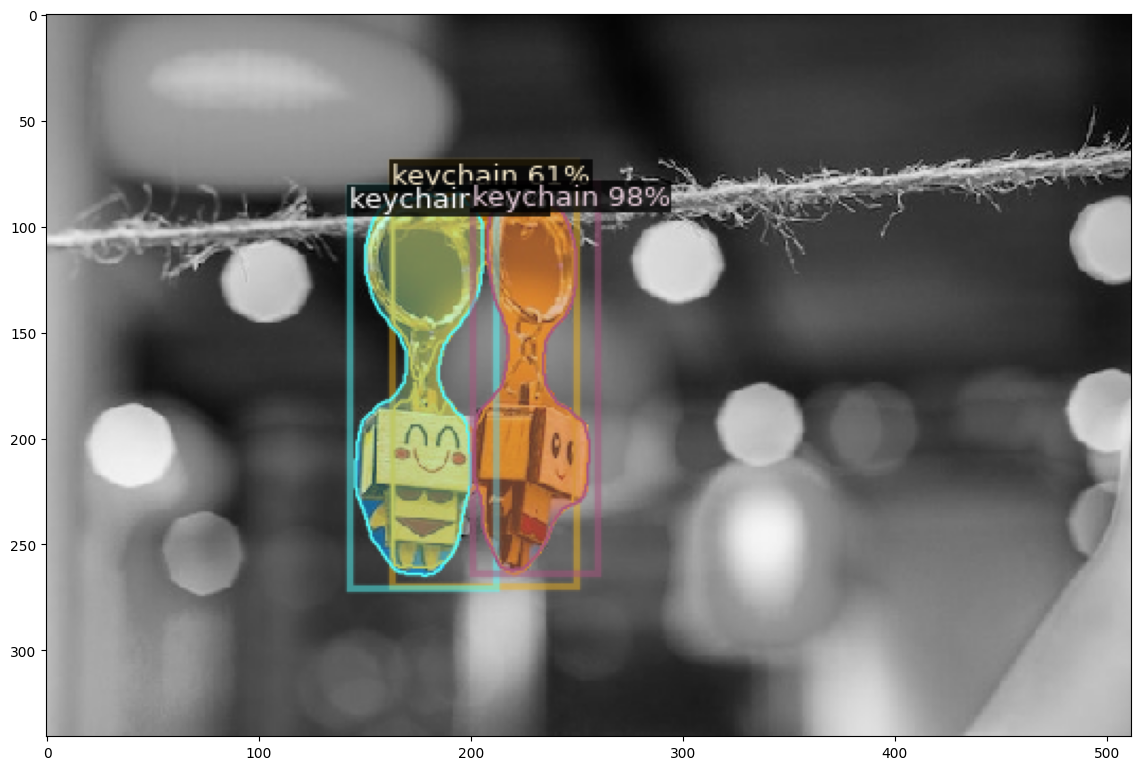

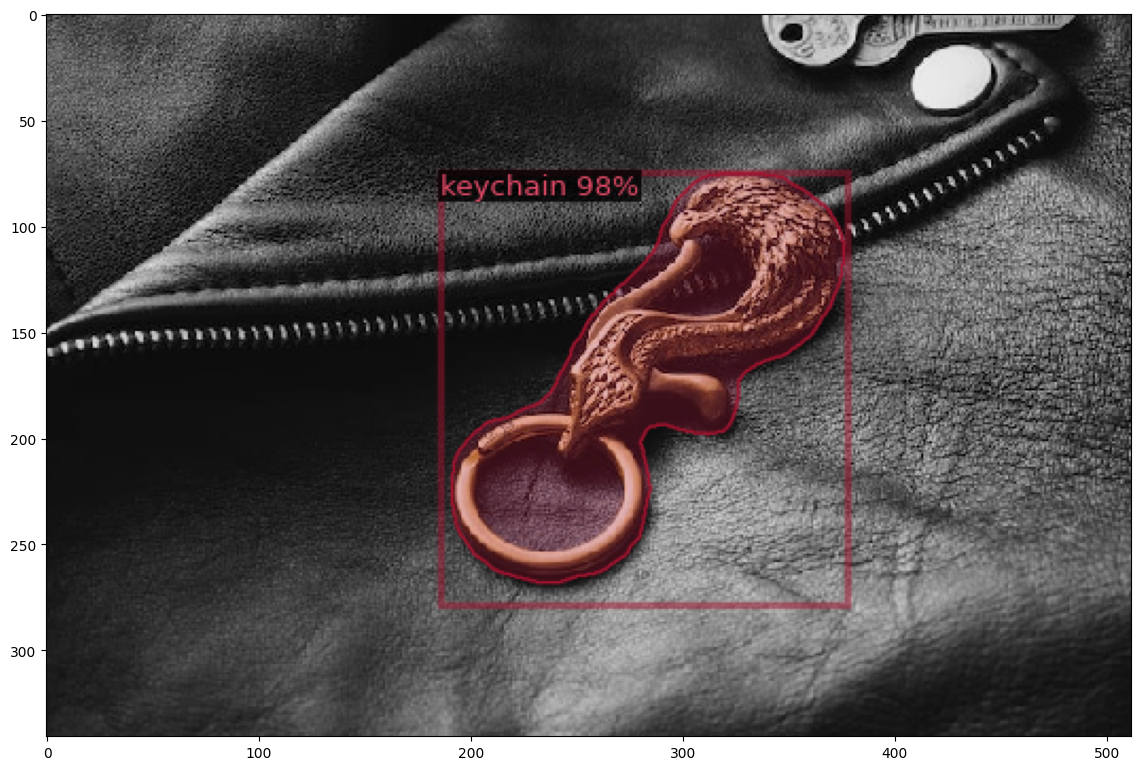

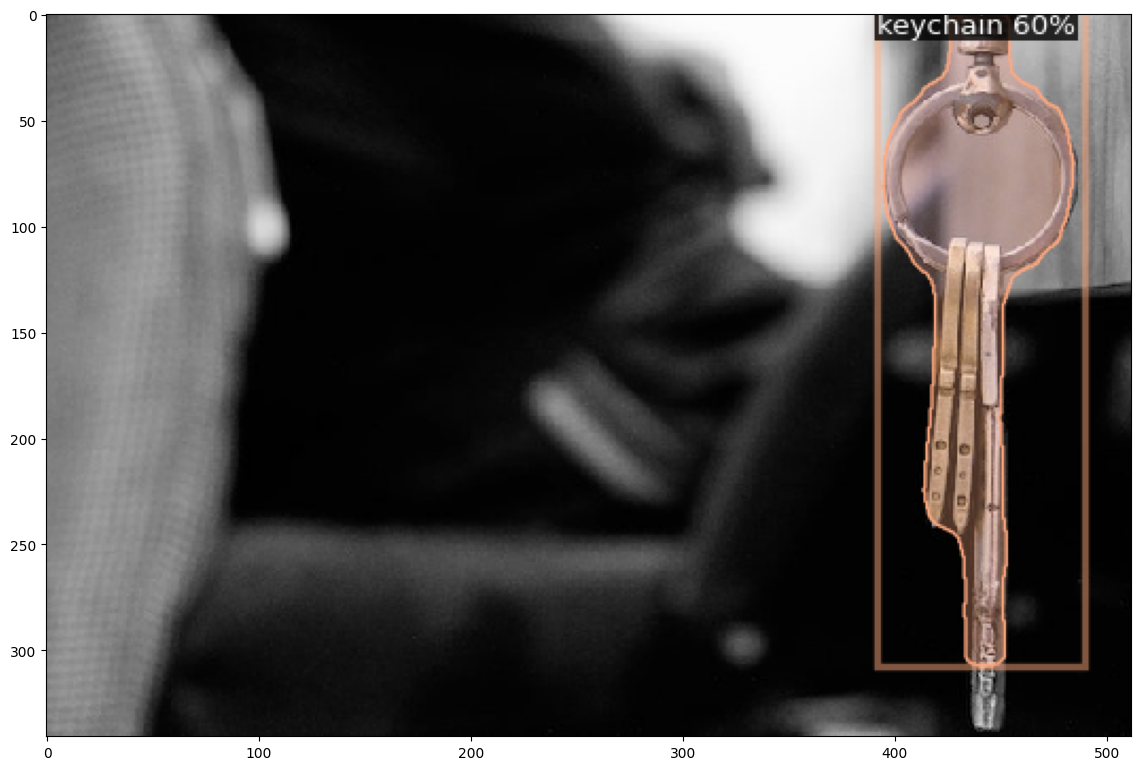

In [11]:
for d in random.sample(test_dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()